#### Imports

In [1]:
import pandas as pd
import numpy as np  
import os
import matplotlib.pyplot as plt
import math
from PIL import Image, ImageOps

from skimage import morphology
from skimage import io
from skimage.segmentation import slic, mark_boundaries

#from os.path import exists

#from pathlib import Path




# Default packages for the minimum example
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score #example for measuring performance


import pickle #for saving/loading trained classifiers

#### Data

In [2]:
file_data = 'data/metadata.csv'
path_image =  'data/images'
path_mask = 'data/masks'
path_masked_image = 'data/masked_images'
file_features = 'features/features.csv'

images_id = os.listdir(path_image)
images_id.remove('.gitkeep')

#Read meta-data into a Pandas dataframe
metadata = pd.read_csv(file_data)

# Extract image IDs and labels from the data. 
#image_id = list(metadata['img_id'])
#label = np.array(metadata['diagnostic'])

### Feature measurements functions

In [5]:
def create_masked_image(path_image, path_mask, path_masked_image, img_filename):
    """
    This function takes in the paths to the images folder, masks folder and 
    masked images folder, and the filename of the image to be masked, and creates 
    a masked image for the specified image using the corresponding mask in the masks folder.
    """
    # Create the masked images folder if it does not exist
    if not os.path.exists(path_masked_image):
        os.makedirs(path_masked_image)

    # Loop through the images folder
    for filename in os.listdir(path_image):
        if filename == img_filename and filename.endswith('.png'): # adjust file extension as needed
            img_path = os.path.join(path_image, filename)
            mask_filename = f"mask_{filename}"
            mask_path = os.path.join(path_mask, mask_filename)
            # Load the image and mask
            img = Image.open(img_path)
            mask = Image.open(mask_path).convert('L')
            # Apply the mask on the image
            masked_img = Image.composite(img, Image.new('RGB', img.size, (0, 0, 0)), mask)
            # Save the masked image
            masked_filename = f"masked_{filename}"
            masked_img.save(os.path.join(path_masked_image, masked_filename))
            return # exit the function after creating the masked image

    # If the specified image filename was not found
    print(f"Error: image {img_filename} not found in {path_image}")

# Loop through the images folder and create a masked image for each image
for filename in os.listdir(path_image):
    create_masked_image(path_image, path_mask, path_masked_image, filename)

# PAT_672_1272_705 <> faulty image, because of extra space in the name

Error: image .gitkeep not found in data/images


In [4]:
''' ASYMMETRY '''  #Okkkk

def fix_mask(mask):
    '''Turns a mask into only black(0) or white(255) pixel values. Put the leison in the
     center of the image '''

    #Make it purely black and white
    bw = np.asarray(mask).copy()
    bw[bw <255] = 0
    mask = Image.fromarray(bw)
    
    #Crop the leison 
    mask_bw = np.where(np.array(mask)==255, 1, 0) #2d array with 0 on black and 1 on white

    row_index =  np.where(np.sum(mask_bw, axis=1)>0)[0] #all the rows with at least one white element 
    first_row , last_row = row_index[0] , row_index[-1]  #first and last row 
    if (last_row - first_row) %2 != 0:
        last_row += 1 #one extra row to make it even and able to halve it

    col_index =  np.where(np.sum(mask_bw, axis=0)>0)[0] #all the col with at least one white element 
    first_col , last_col = col_index[0] , col_index[-1]  #first and last col 
    if (last_col - first_col) %2 != 0:
        last_col += 1

    cropped_mask = mask.crop((first_col,first_row,last_col,last_row))

    #Add borders
    old_width , old_height = cropped_mask.size 
    fixed_mask = ImageOps.expand(cropped_mask, border = int(old_width/2))

    return fixed_mask


def test_asymmetry(mask):
    '''Takes a mask image, halves it vertically, compares both sides. Returns an index of asymmetry 
    as the proportion of leisure that differs on both sides over the total leison'''

    width,height = mask.size

    #Cut in half
    left = mask.crop((0, 0, int(width/2), height)) #left part of picture (left, top, right, bottom)
    right = mask.crop((int(width/2), 0, width, height)) #right part of picture
    right = right.transpose(Image.FLIP_LEFT_RIGHT) #flip right part to compare

    #Compairing both sides
    asym = np.sum(np.where(np.array(left) != np.array(right), 1, 0))
    total_white = np.sum(np.where(np.array(mask)==255, 1, 0))
   
    return round((asym/total_white), 3) #Maybe *10 ??? Very small number 


def get_asymmetry(mask):
    '''Returns the asymmetry for a given leison by rotating the mask image by several angles, measuring 
     the proportion of asymmetry on each, and returning the minimum index. '''
    
    #Leison in the center of the image. Expand black borders to give freedom when rotating image. 
    mask = fix_mask(mask)

    asym = [test_asymmetry(mask.rotate(angle)) for angle in [0,15,30,45,60,75,90]]

    return round(np.min(asym), 3)




In [5]:
def get_color_variability(masked_image, measure='variance'):
    # Find the non-black pixels (i.e., the lesion pixels)
    non_black_pixels = np.where(np.any(masked_image > 0, axis=-1))

    # Extract the color values of the non-black pixels
    r = masked_image[non_black_pixels][:, 0]
    g = masked_image[non_black_pixels][:, 1]
    b = masked_image[non_black_pixels][:, 2]

    # Divide the lesion pixels into segments of similar color
    segments_slic = slic(masked_image[non_black_pixels], n_segments=50, compactness=10, sigma=3, start_label=1)

    # Compute the color variability for each segment that is within the lesion
    segment_color_variability = []
    for i in range(1, np.max(segments_slic) + 1):
        segment_pixels = np.where(segments_slic == i)[0]
        segment_r = r[segment_pixels]
        segment_g = g[segment_pixels]
        segment_b = b[segment_pixels]

        if measure == 'variance':
            rgb_variability = (np.var(segment_r), np.var(segment_g), np.var(segment_b))
        elif measure == 'standard_deviation':
            rgb_variability = (np.std(segment_r), np.std(segment_g), np.std(segment_b))
        else:
            return None

        segment_color_variability.append(np.mean(rgb_variability))

    return np.mean(segment_color_variability)


In [ ]:
def get_color_variability(masked_image, measure='variance'):
    # Find the non-black pixels (i.e., the lesion pixels)
    non_black_pixels = np.where(np.any(masked_image > 0, axis=-1))

    # Extract the color values of the non-black pixels
    r = masked_image[non_black_pixels][:, 0]
    g = masked_image[non_black_pixels][:, 1]
    b = masked_image[non_black_pixels][:, 2]

    # Divide the lesion pixels into segments of similar color
    segments_slic = slic(masked_image[non_black_pixels], n_segments=50, compactness=10, sigma=3, start_label=1)

    # Compute the color variability for each segment that is within the lesion
    segment_color_variability_r = []
    segment_color_variability_g = []
    segment_color_variability_b = []
    for i in range(1, np.max(segments_slic) + 1):
        segment_pixels = np.where(segments_slic == i)[0]
        segment_r = r[segment_pixels]
        segment_g = g[segment_pixels]
        segment_b = b[segment_pixels]

        if measure == 'variance':
            rgb_variability = (np.var(segment_r), np.var(segment_g), np.var(segment_b))
        elif measure == 'standard_deviation':
            rgb_variability = (np.std(segment_r), np.std(segment_g), np.std(segment_b))
        else:
            return None

        segment_color_variability_r.append(rgb_variability[0])
        segment_color_variability_g.append(rgb_variability[1])
        segment_color_variability_b.append(rgb_variability[2])

    return np.mean(segment_color_variability_r), np.mean(segment_color_variability_g), np.mean(segment_color_variability_b)


In [6]:
####### BORDER #########

def area_perimeter(mask): 
    '''Measures the area and perimeter of a mask image'''

    mask = np.array(mask)
    mask = np.where(mask==255, 1, 0)

    #area: the sum of all white pixels in the mask image
    area = np.sum(mask)

    #perimeter: first find which pixels belong to the perimeter.
    struct_el = morphology.disk(1)
    mask_eroded = morphology.binary_erosion(mask, struct_el)
    image_perimeter = mask - mask_eroded
    perimeter = np.sum(image_perimeter)

    return area, perimeter

 
def get_compactness(mask):
    '''Computes and returns the compactness of a figure'''

    area, perimeter = area_perimeter(mask)

    return round( (perimeter ** 2) /(4* np.pi *area), 4)


### Measuring features ---> csv

In [ ]:
''''For quick testing of functions. Delete after '''

data = {'images_id': images_id, 'asym': [],'area/perimeter': [] ,'compactness' : []}

for i, image in enumerate(images_id):

    #Read image and mask
    file_image = path_image + '/' + image
    #im = plt.imread(file_image)
    im = Image.open(file_image) #I've been using this for asymm
    im_np = np.float16(im)

    file_mask = path_mask + '/mask_' + image
    #mask = plt.imread(file_mask)
    mask = Image.open(file_mask) #I've been using this for asymm
    mask_np = np.float16(mask)

    data['asym'].append(get_asymmetry(mask))
    data['area/perimeter'].append(area_perimeter(mask))
    data['compactness'].append(get_compactness(mask))

df = pd.DataFrame(data)
    
df
#ex_mask = Image.open(path_mask + '/mask_' + images_id[-1])
#fix_mask(ex_mask)

In [18]:
''''  OK   '''

# Create an empty dataframe to store the features, save index as image_id
features = pd.DataFrame(index=images_id)

# Create columns image_id, asymmetry, color_variability, and compactness
features['image_id'] = images_id
features['asymmetry'] = [get_asymmetry(Image.open(path_mask + '/mask_' + image)) for image in images_id]
features['color_variability'] = [get_color_variability(np.array(Image.open(path_image + '/' + image)), measure='variance') for image in images_id]
features['compactness'] = [get_compactness(Image.open(path_mask + '/mask_' + image)) for image in images_id]
# Add a column for the diagnosis called 'diagnostic' and take the values from the 'diagnostic' column in the metadata dataframe based on common values in left dataframe from column "image_id" and right dataframe "img_id"
features['diagnostic'] = features['image_id'].map(metadata.set_index('img_id')['diagnostic'])
# Add a column called 'healthy' that is 1 if the diagnostic is in ["NEV", "SEK", "ACK"] and 0 if it is ["MEL", "SCC", "BCC"]
features['healthy'] = features['diagnostic'].isin(["NEV", "SEK", "ACK"]).astype(int)

# Save the features dataframe to csv file
features.to_csv('features.csv', index=False)

C:\Users\raivi\AppData\Local\Temp\ipykernel_28656\3605390448.py:43: DeprecationWarning: FLIP_LEFT_RIGHT is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_LEFT_RIGHT instead.
  right = right.transpose(Image.FLIP_LEFT_RIGHT) #flip right part to compare


### Train classifiers

ACK 0.31766753698868583
BCC 0.3677110530896432
MEL 0.022628372497824196
NEV 0.1061792863359443
SCC 0.0835509138381201
SEK 0.10226283724978243


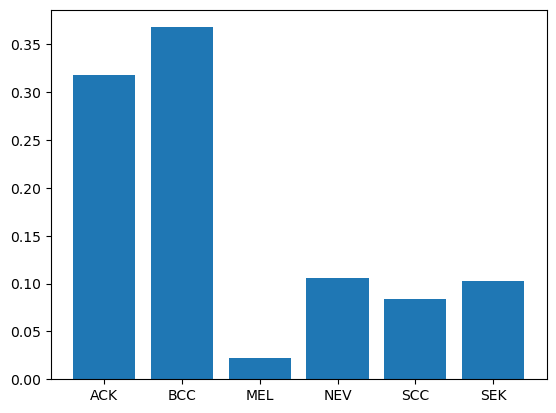

In [10]:
bum = pd.read_csv('data/metadata.csv')

# get unique values of column "diagnostic" and calculate percentages of each values in the set
# and plot the percentages
diagnostic = bum['diagnostic']
unique, counts = np.unique(diagnostic, return_counts=True)
percentages = counts/len(diagnostic)
plt.bar(unique, percentages)

# print the percentages
for i, unique_value in enumerate(unique):
    print(unique_value, percentages[i])

# convert to percentages
percentages = percentages * 100

In [49]:
# Load the features - remember the example features are not informative
df_features = pd.read_csv(file_features)


# Make the dataset, you can select different classes (see task 0)
x = np.array(df_features[feature_names])
#y =  label == 'NEV'   #now True means healthy nevus, False means something else
patient_id = metadata['patient_id']

patient_id





0       PAT_1516
1         PAT_46
2       PAT_1545
3       PAT_1989
4        PAT_684
          ...   
2293    PAT_1708
2294      PAT_46
2295    PAT_1343
2296     PAT_326
2297    PAT_1714
Name: patient_id, Length: 2298, dtype: object

### Evaluate classifier

In [ ]:
'''This is still copy/paste Veronika's --- still need changes '''


# The function that should classify new images. 
# The image and mask are the same size, and are already loaded using plt.imread
def classify(img, mask):
    
    
     #Resize the image etc, if you did that during training
    
     #Extract features (the same ones that you used for training)
     x = extract_features(img, mask)
         
     
     #Load the trained classifier
     classifier = pickle.load(open('groupXY_classifier.sav', 'rb'))
    
    
     #Use it on this example to predict the label AND posterior probability
     pred_label = classifier.predict(x)
     pred_prob = classifier.predict_proba(x)
     
     
     #print('predicted label is ', pred_label)
     #print('predicted probability is ', pred_prob)
     return pred_label, pred_prob
 
    
# The TAs will call the function above in a loop, for external test images/masks

In [ ]:
'''holaaaaa'''